# Getting Sense of Data

In [ ]:
import pandas as pd

file_path = 'combinedData_Exp1.csv'
df = pd.read_csv(file_path)
print(df.head())
print(df.shape)

In [ ]:
df['sectionType'].value_counts()

,count
sectionType,
mainTask,33280
pracTask,5680
instructions,676
pracFeedback,450
blockBreak,195


In [ ]:
main_df = df[df['sectionType'] == 'mainTask']

In [ ]:
main_df.head(5)

,expStage,sectionType,block,blockType,trialCount,blockTrialCount,acc,RT,stimulus,stimCongruency,taskCue,switchType,partKey,stimOnset,respOnset,correct_resp,sectionStart,sectionEnd,sectionTime,subject
77,task,mainTask,1,B,1.0,1.0,1.0,952.0,1.0,i,m,n,109.0,410814.0,411766.0,109.0,NaN,NaN,NaN,Sub1
78,task,mainTask,1,B,2.0,2.0,1.0,938.0,2.0,c,m,r,109.0,413687.0,414625.0,109.0,NaN,NaN,NaN,Sub1
79,task,mainTask,1,B,3.0,3.0,1.0,748.0,1.0,i,p,s,122.0,416556.0,417304.0,122.0,NaN,NaN,NaN,Sub1
80,task,mainTask,1,B,4.0,4.0,1.0,966.0,3.0,i,m,s,109.0,419356.0,420322.0,109.0,NaN,NaN,NaN,Sub1
81,task,mainTask,1,B,5.0,5.0,1.0,848.0,6.0,i,m,r,122.0,422261.0,423109.0,122.0,NaN,NaN,NaN,Sub1


In [ ]:
main_df['acc'].value_counts()

,count
acc,
1.0,29740
0.0,3540


In [ ]:
main_df['trialCount'].value_counts()

,count
trialCount,
1.0,65
2.0,65
351.0,65
350.0,65
349.0,65
...,...
166.0,65
165.0,65
164.0,65


In [ ]:
main_df['stimCongruency'].value_counts()

,count
stimCongruency,
i,16640
c,16640


In [ ]:
main_df['taskCue'].value_counts() # p-parity, m-magnitude

,count
taskCue,
m,16640
p,16640


In [ ]:
main_df['switchType'].value_counts() #s-switch, r-repeat

,count
switchType,
r,16640
s,16380
n,260


In [ ]:
task_combos = pd.crosstab(main_df['switchType'], main_df['stimCongruency'])
task_combos

stimCongruency,c,i
switchType,,
n,134,126
r,8299,8341
s,8207,8173


In [ ]:
main_df.iloc[1000]

,1178
expStage,task
sectionType,mainTask
block,4
blockType,A
trialCount,489.0
blockTrialCount,105.0
acc,0.0
RT,717.0
stimulus,7.0
stimCongruency,i


In [ ]:
main_df['block'].value_counts()

,count
block,
1,8320
2,8320
3,8320
4,8320


# Creating Input Layer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

In [ ]:
os.chdir('/content/drive/My Drive/CS 230: Deep Learning/stability-flexibility-tradeoff-master/Participant Data')
df_exp_1 = pd.read_csv('Experiment 1/combinedData_Exp1.csv')
!ls

'Experiment 1'	'Experiment 2'	'Experiment 3'


In [ ]:
# Filter the DataFrame to include only rows where expStage is 'task' and sectionType is 'mainTask'
df_exp_1_task = df_exp_1[(df_exp_1['expStage'] == 'task') & (df_exp_1['sectionType'] == 'mainTask')].copy()

# Add previous stimulus and taskCue columns
df_exp_1_task.loc[:, 'prev_stimulus'] = df_exp_1_task['stimulus'].shift(1)
df_exp_1_task.loc[:, 'prev_taskCue'] = df_exp_1_task['taskCue'].shift(1)


# Select only the useful columns
df_exp_1_input = df_exp_1_task[['stimulus', 'taskCue', 'prev_stimulus', 'stimCongruency', 'switchType', 'prev_taskCue', 'acc', 'RT']]
df_exp_1_input_acc_only = df_exp_1_input[df_exp_1_input['acc'] == 1]

# Remove any rows where switchType is n
df_exp_1_input_acc_only = df_exp_1_input_acc_only[df_exp_1_input_acc_only['switchType'] != 'n']


In [ ]:
df_exp_1_input_acc_only


,stimulus,taskCue,prev_stimulus,stimCongruency,switchType,prev_taskCue,acc,RT
78,2.0,m,1.0,c,r,m,1.0,938.0
79,1.0,p,2.0,i,s,m,1.0,748.0
80,3.0,m,1.0,i,s,p,1.0,966.0
81,6.0,m,3.0,i,r,m,1.0,848.0
82,3.0,p,6.0,i,s,m,1.0,1092.0
...,...,...,...,...,...,...,...,...
40276,7.0,p,4.0,i,s,m,1.0,726.0
40277,9.0,m,7.0,i,s,p,1.0,733.0
40278,6.0,p,9.0,c,s,m,1.0,622.0
40279,7.0,p,6.0,i,r,p,1.0,599.0


[link text](https://)# Linear Regression # Encode binary categorical vars as binary numerical
binary_cols = ['taskCue', 'stimCongruency', 'switchType', 'prev_taskCue']
binary_mapping = {'i': 1, 'c': 0, 'r': 0, 's': 1, 'p': 1, 'm': 0}

for col in binary_cols:
    X[col] = X[col].map(binary_mapping)

In [ ]:
features = ['stimulus', 'taskCue', 'prev_stimulus', 'stimCongruency', 'switchType', 'prev_taskCue']
target = 'RT'

X = df_exp_1_input_acc_only[features].copy()
y = df_exp_1_input_acc_only[target].values

# Encode binary categorical vars as binary numerical
binary_cols = ['taskCue', 'stimCongruency', 'switchType', 'prev_taskCue']
binary_mapping = {'i': 0, 'c': 1, 'r': 0, 's': 1, 'p': 1, 'm': 0}

for col in binary_cols:
    X[col] = X[col].map(binary_mapping)


X = X.values.astype(np.float32)
y = y.astype(np.float32)/1000

# Split the data into training and test sets that are nunpy arrays
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

X_train


array([[7., 0., 2., 0., 0., 0.],
       [2., 1., 7., 1., 0., 1.],
       [1., 0., 2., 0., 1., 1.],
       ...,
       [8., 0., 4., 1., 0., 0.],
       [1., 1., 3., 1., 1., 0.],
       [1., 0., 8., 1., 1., 1.]], dtype=float32)

In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(np.array(X_train))
X_test_tensor = torch.tensor(np.array(X_test))
y_train_tensor = torch.tensor(np.array(y_train)).unsqueeze(1)
y_test_tensor = torch.tensor(np.array(y_test)).unsqueeze(1)

# Check for NaNs or Infs in target data
print(torch.isnan(X_train_tensor).any())
print(torch.isinf(X_train_tensor).any())

print(torch.isnan(y_train_tensor).any())
print(torch.isinf(y_train_tensor).any())

X_train

tensor(False)
tensor(False)
tensor(False)
tensor(False)


array([[7., 0., 2., 0., 0., 0.],
       [2., 1., 7., 1., 0., 1.],
       [1., 0., 2., 0., 1., 1.],
       ...,
       [8., 0., 4., 1., 0., 0.],
       [1., 1., 3., 1., 1., 0.],
       [1., 0., 8., 1., 1., 1.]], dtype=float32)

In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

# Define the input dimension
input_dim = X_train_tensor.shape[1]
input_dim

# Instantiate the model, loss function, and optimizer
model = LinearRegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# Training the linear regression model
num_epochs = 1000
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()  # Clear the gradients

    # Forward pass
    y_pred = model(X_train_tensor)
    print(y_pred)
    loss = criterion(y_pred, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Record the training loss
    train_losses.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Convert loss to numpy array for easy plotting
train_losses = np.array(train_losses)

Streaming output truncated to the last 5000 lines.
        [0.8067]], grad_fn=<AddmmBackward0>)
tensor([[0.6276],
        [0.7457],
        [0.7146],
        ...,
        [0.6563],
        [0.7680],
        [0.8069]], grad_fn=<AddmmBackward0>)
tensor([[0.6278],
        [0.7457],
        [0.7149],
        ...,
        [0.6565],
        [0.7680],
        [0.8071]], grad_fn=<AddmmBackward0>)
tensor([[0.6281],
        [0.7458],
        [0.7152],
        ...,
        [0.6567],
        [0.7680],
        [0.8073]], grad_fn=<AddmmBackward0>)
tensor([[0.6283],
        [0.7458],
        [0.7155],
        ...,
        [0.6569],
        [0.7680],
        [0.8074]], grad_fn=<AddmmBackward0>)
tensor([[0.6286],
        [0.7458],
        [0.7158],
        ...,
        [0.6571],
        [0.7680],
        [0.8076]], grad_fn=<AddmmBackward0>)
tensor([[0.6288],
        [0.7459],
        [0.7161],
        ...,
        [0.6573],
        [0.7681],
        [0.8078]], grad_fn=<AddmmBackward0>)
tensor([[0.6291]

Test Loss: 0.0479


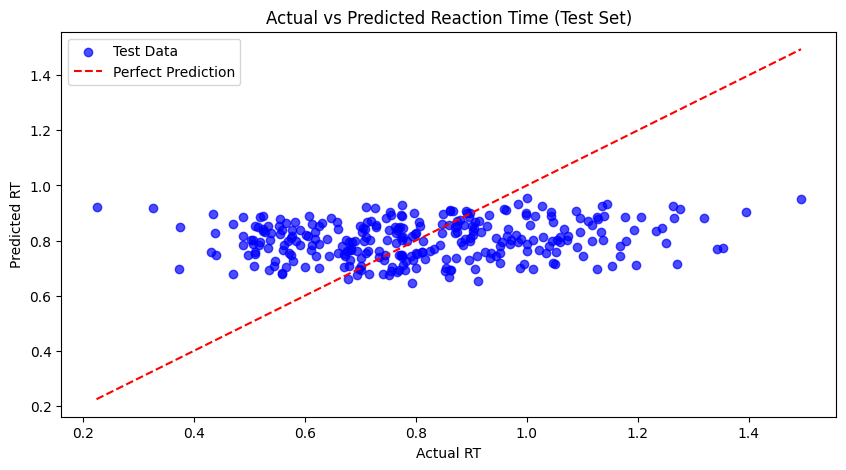

In [ ]:
# Evaluation on the test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    test_loss = criterion(y_pred_test, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

    # Plotting the predictions vs actual values for the test set
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_tensor.numpy(), y_pred_test.numpy(), label='Test Data', alpha=0.7, color='blue')
    plt.plot([min(y_test_tensor.numpy()), max(y_test_tensor.numpy())],
             [min(y_test_tensor.numpy()), max(y_test_tensor.numpy())],
             color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual RT')
    plt.ylabel('Predicted RT')
    plt.legend()
    plt.title('Actual vs Predicted Reaction Time (Test Set)')
    plt.show()

# LSTM Model #1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [ ]:
# Selecting relevant features and target
features = ['stimulus', 'taskCue', 'prev_stimulus', 'prev_taskCue', 'stimCongruency', 'switchType']
target = 'RT'

In [ ]:
# Divide into input and output
X = df_exp_1_input_acc_only[features].copy()
y = df_exp_1_input_acc_only[target].values

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(exclude=['float64', 'int64']).columns

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols)


,stimulus,prev_stimulus,taskCue_m,taskCue_p,prev_taskCue_m,prev_taskCue_p,stimCongruency_c,stimCongruency_i,switchType_n,switchType_r,switchType_s
77,-1.457160,NaN,True,False,False,False,False,True,True,False,False
78,-1.092941,-1.459909,True,False,True,False,True,False,False,True,False
79,-1.457160,-1.095297,False,True,True,False,False,True,False,False,True
80,-0.728721,-1.459909,True,False,False,True,False,True,False,False,True
81,0.363938,-0.730684,True,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
40276,0.728158,-0.366072,False,True,True,False,False,True,False,False,True
40277,1.456597,0.727766,True,False,False,True,False,True,False,False,True
40278,0.363938,1.456991,False,True,True,False,True,False,False,False,True
40279,0.728158,0.363154,False,True,False,True,False,True,False,True,False


In [ ]:
# Normalize features
scaler = StandardScaler()
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

# Ensure data is in float32 format for PyTorch
X_processed = X_encoded.values.astype(np.float32)
y_processed = y.astype(np.float32)


In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

X_train


array([[-1.0929406 ,  0.7277661 ,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.4565969 ,  0.7277661 ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.72872096, -1.4599092 ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.3645013 ,  0.7277661 ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-1.4571602 , -0.36607155,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.7281576 , -0.36607155,  1.        , ...,  0.        ,
         0.        ,  1.        ]], dtype=float32)

In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Add time dimension if needed
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)    # Add time dimension if needed
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape)


torch.Size([23792, 11]) torch.Size([5948, 11]) torch.Size([23792]) torch.Size([5948])


In [ ]:
# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Define model, loss function and optimizer
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 1
num_layers = 2

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state and cell state (h0, c0) to zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Define model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
hidden_dim = 64
output_dim = 1
num_layers = 2

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ensure the input tensor is of shape (batch_size, seq_len, input_dim)
if len(X_train_tensor.shape) == 2:
    X_train_tensor = X_train_tensor.unsqueeze(1)  # Add time dimension
if len(X_test_tensor.shape) == 2:
    X_test_tensor = X_test_tensor.unsqueeze(1)  # Add time dimension

# Training loop
num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        # Forward pass
        output = model(X_batch)
        loss = criterion(output, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss: {test_loss.item()}')

In [ ]:
# Train the model
num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        output = model(X_batch)
        loss = criterion(output, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze()
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

# Example: converting predictions to numpy
y_pred_np = y_pred.numpy()